In [316]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [317]:
df1 = pd.read_excel('GLD.xls')
df2 = pd.read_excel('GDX.xls')

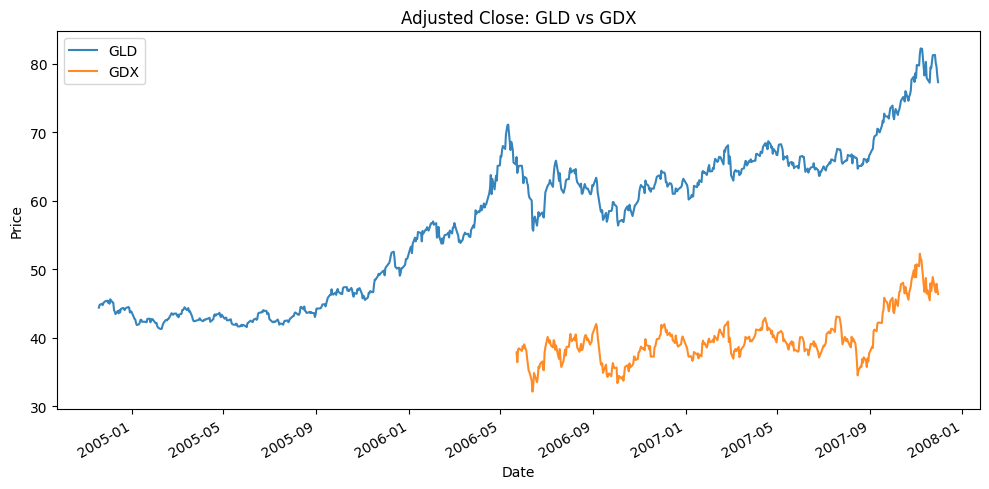

In [318]:
# Plot Adjusted Close for GLD and GDX
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df1['Date'], df1['Adj Close'], label='GLD', alpha=0.9)
ax.plot(df2['Date'], df2['Adj Close'], label='GDX', alpha=0.9)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.set_title('Adjusted Close: GLD vs GDX')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [319]:
df = pd.merge(df1, df2, on='Date', suffixes=('_GLD', '_GDX'))
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head()

,Open_GLD,High_GLD,Low_GLD,Close_GLD,Volume_GLD,Adj Close_GLD,Open_GDX,High_GDX,Low_GDX,Close_GDX,Volume_GDX,Adj Close_GDX
Date,,,,,,,,,,,,
2006-05-23,65.99,67.16,65.91,66.38,10509700,66.38,37.75,39.22,37.75,37.96,620900,37.85
2006-05-24,64.83,65.16,63.22,64.06,11065600,64.06,37.13,37.57,35.87,36.52,638600,36.41
2006-05-25,64.12,64.76,63.76,64.70,6505400,64.70,37.18,38.32,36.98,38.32,367000,38.21
2006-05-26,65.01,65.10,63.75,65.10,5265900,65.10,38.74,38.74,37.77,38.55,269400,38.44
2006-05-30,65.20,66.24,65.00,65.11,8240200,65.11,39.50,39.72,38.11,38.17,559100,38.06


In [320]:
trainset = np.arange(0, 252)
testset = np.arange(trainset.shape[0], df.shape[0])
print("Trainset Length:", len(trainset))
print("Testset Length:", len(testset))


Trainset Length: 252
Testset Length: 133


In [321]:
model = sm.OLS(df.loc[:, 'Adj Close_GLD'].iloc[trainset], df.loc[:, 'Adj Close_GDX'].iloc[trainset])
results = model.fit()

In [322]:
hedgeRatio = results.params.iloc[0]  # scalar (book uses hedgeRatio[0]; .iloc[0] avoids KeyError)
hedgeRatio

np.float64(1.6310089532247034)

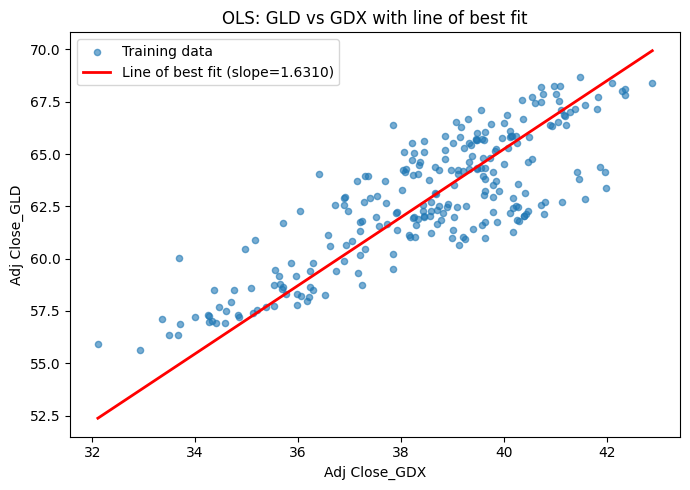

In [323]:
# Scatter: GDX vs GLD (training data) with OLS line of best fit
x_train = df.loc[:, 'Adj Close_GDX'].iloc[trainset]
y_train = df.loc[:, 'Adj Close_GLD'].iloc[trainset]

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x_train, y_train, alpha=0.6, s=20, label='Training data')
x_line = np.linspace(x_train.min(), x_train.max(), 100)
ax.plot(x_line, hedgeRatio * x_line, 'r-', lw=2, label=f'Line of best fit (slope={hedgeRatio:.4f})')
ax.set_xlabel('Adj Close_GDX')
ax.set_ylabel('Adj Close_GLD')
ax.legend()
ax.set_title('OLS: GLD vs GDX with line of best fit')
plt.tight_layout()
plt.show()

In [324]:
spread = df.loc[:, 'Adj Close_GLD'] - hedgeRatio * df.loc[:, 'Adj Close_GDX']
spread.head()

Date
2006-05-23    4.646311
2006-05-24    4.674964
2006-05-25    2.379148
2006-05-26    2.404016
2006-05-30    3.033799
dtype: float64

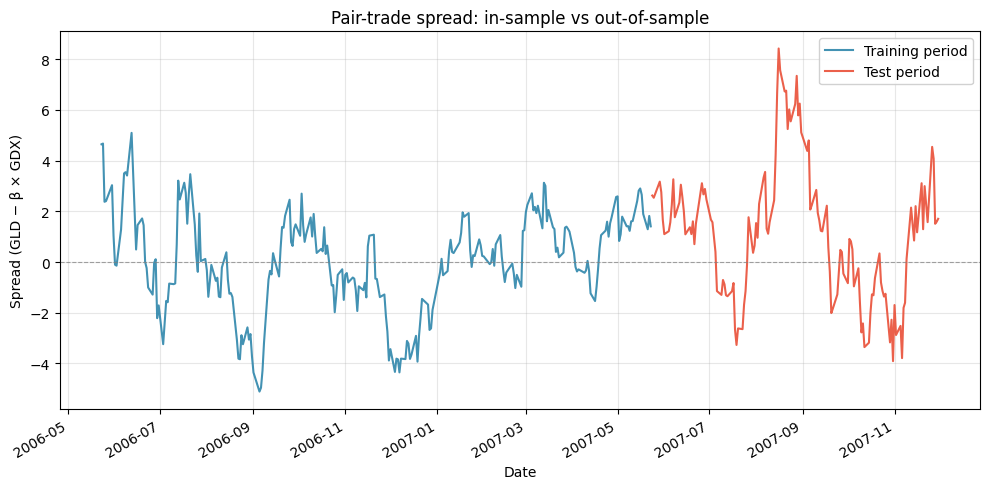

In [325]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(spread.index[trainset], spread.iloc[trainset], color='#2E86AB', linewidth=1.5, label='Training period', alpha=0.9)
ax.plot(spread.index[testset], spread.iloc[testset], color='#E94F37', linewidth=1.5, label='Test period', alpha=0.9)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Spread (GLD − β × GDX)')
ax.set_title('Pair-trade spread: in-sample vs out-of-sample')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [326]:
spreadMean = np.mean(spread.iloc[trainset])
spreadStd = np.std(spread.iloc[trainset])

df['zscore'] = (spread - spreadMean) / spreadStd
df['positions_GLD_Long'] = 0
df['positions_GDX_Long'] = 0
df['positions_GLD_Short'] = 0
df['positions_GDX_Short'] = 0

df.loc[df['zscore'] >= 2, ('positions_GLD_Short', 'positions_GDX_Short')] = [-1, 1]   # Short spread
df.loc[df['zscore'] <= -2, ('positions_GLD_Long', 'positions_GDX_Long')] = [1, -1]  # Buy spread
df.loc[df['zscore'] <= 1, ('positions_GLD_Short', 'positions_GDX_Short')] = 0       # Exit short
df.loc[df['zscore'] >= -1, ('positions_GLD_Long', 'positions_GDX_Long')] = 0       # Exit long
df.ffill(inplace=True)  # carry forward positions (book: fillna(method='ffill'))

,Open_GLD,High_GLD,Low_GLD,Close_GLD,Volume_GLD,Adj Close_GLD,Open_GDX,High_GDX,Low_GDX,Close_GDX,Volume_GDX,Adj Close_GDX,zscore,positions_GLD_Long,positions_GDX_Long,positions_GLD_Short,positions_GDX_Short
Date,,,,,,,,,,,,,,,,,
2006-05-23,65.99,67.16,65.91,66.38,10509700,66.38,37.75,39.22,37.75,37.96,620900,37.85,2.362182,0,0,-1,1
2006-05-24,64.83,65.16,63.22,64.06,11065600,64.06,37.13,37.57,35.87,36.52,638600,36.41,2.376914,0,0,-1,1
2006-05-25,64.12,64.76,63.76,64.70,6505400,64.70,37.18,38.32,36.98,38.32,367000,38.21,1.196462,0,0,0,0
2006-05-26,65.01,65.10,63.75,65.10,5265900,65.10,38.74,38.74,37.77,38.55,269400,38.44,1.209248,0,0,0,0
2006-05-30,65.20,66.24,65.00,65.11,8240200,65.11,39.50,39.72,38.11,38.17,559100,38.06,1.533068,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-11-26,82.25,82.25,81.13,81.30,7440200,81.30,49.43,49.43,46.85,47.06,1966500,47.06,2.309945,0,0,-1,1
2007-11-27,80.70,80.89,79.81,80.10,7229900,80.10,46.84,46.84,45.74,46.61,2329700,46.61,2.070316,0,0,-1,1
2007-11-28,79.42,79.87,78.76,79.57,9706700,79.57,46.11,48.00,46.06,47.86,3893200,47.86,0.749522,0,0,0,0


In [327]:
positions_Long = df.loc[:, ('positions_GLD_Long', 'positions_GDX_Long')]
positions_Short = df.loc[:, ('positions_GLD_Short', 'positions_GDX_Short')]

positions = np.array(positions_Long) + np.array(positions_Short)
positions = pd.DataFrame(positions, index=df.index, columns=['GLD', 'GDX'])
positions

,GLD,GDX
Date,,
2006-05-23,-1,1
2006-05-24,-1,1
2006-05-25,0,0
2006-05-26,0,0
2006-05-30,0,0
...,...,...
2007-11-26,-1,1
2007-11-27,-1,1
2007-11-28,0,0


In [328]:
# Match book: pnl = (positions.shift() * dailyret).sum(axis=1)
dailyret = df.loc[:, ('Adj Close_GLD', 'Adj Close_GDX')].pct_change()
pnl = (np.array(positions.shift()) * np.array(dailyret)).sum(axis=1)
pnl = np.asarray(pnl).ravel()  # ensure 1d array so pnl[trainset], pnl[testset] match book

In [329]:
sharpeTrainset = np.sqrt(252) * np.mean(pnl[trainset[1:]]) / np.std(pnl[trainset[1:]])
sharpeTrainset

np.float64(1.9182982282569077)

In [330]:
# Book uses pnl[testset] (all test days); use same to match book Sharpe
sharpeTestset = np.sqrt(252) * np.mean(pnl[testset]) / np.std(pnl[testset])
sharpeTestset

np.float64(1.494313761833427)

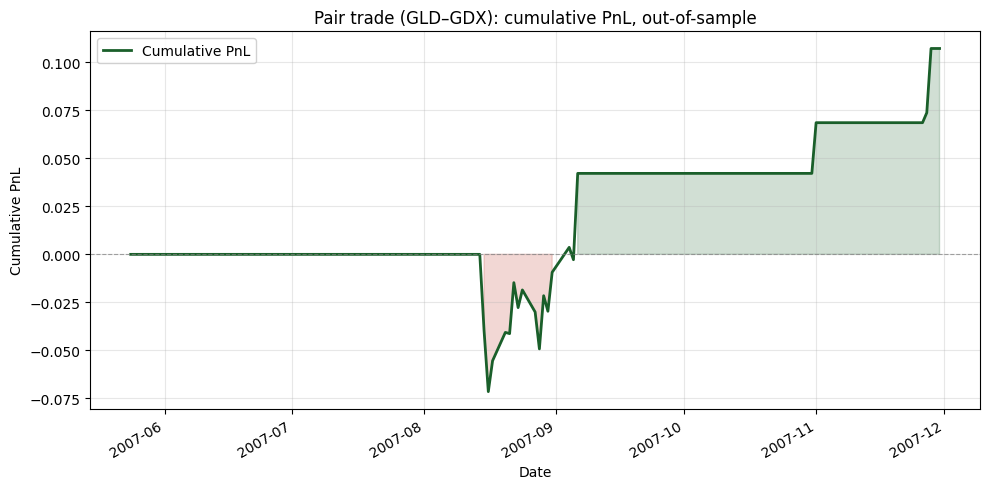

In [331]:
# Cumulative PnL on test set
fig, ax = plt.subplots(figsize=(10, 5))
cum_pnl = np.cumsum(pnl[testset])
dates_test = df.index[testset]
ax.plot(dates_test, cum_pnl, color='#1a5f2a', linewidth=2, label='Cumulative PnL')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
ax.fill_between(dates_test, 0, cum_pnl, where=(cum_pnl >= 0), color='#1a5f2a', alpha=0.2)
ax.fill_between(dates_test, 0, cum_pnl, where=(cum_pnl < 0), color='#c0392b', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative PnL')
ax.set_title('Pair trade (GLD–GDX): cumulative PnL, out-of-sample')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()